In [1]:
import torch
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from model import CGMPredictor
from dataset import CGMDataset, collate_fn

# Define device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
val_dataset = CGMDataset(file="./Datasets", split="val", max_len=512*4, pred_time=90, augment=False, max_deviation=30)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=True,
)


Users loaded: 100%|██████████| 1673/1673 [00:08<00:00, 207.21it/s]


In [10]:


# Assuming you have a model class defined elsewhere
model = CGMPredictor(
    n_embd=8*48,
    n_head=8,
    n_layer=3,
    dropout=0.3,
)
model = torch.compile(model)
model.to(device)
model.eval()

print(model.num_params())

17828401


In [13]:

# Define loss function
criterion = nn.L1Loss()  # Replace with your loss function if different

In [14]:
val_dataset.max_deviation = 30
val_dataset.max_len = 512*10
val_dataset.max_range = 1.2
val_dataset.augment = False

In [33]:
iteration = 19000
model_path = f'./model_iter_{iteration}.pth'
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [16]:
import tqdm
num_iter = 1000

total_loss, total_samples = 0, 0
with torch.no_grad():
    for i in tqdm.tqdm(range(num_iter)):
        while total_samples < num_iter:
            sample = val_dataset[0]
            cgm = sample['cgm'].to(device).unsqueeze(0)
            basal = sample['basal'].to(device).unsqueeze(0)
            bolus = sample['bolus'].to(device).unsqueeze(0)
            cgm_time = sample['cgm_time'].to(device).unsqueeze(0)
            basal_time = sample['basal_time'].to(device).unsqueeze(0)
            bolus_time = sample['bolus_time'].to(device).unsqueeze(0)
            target_cgm = sample['target_cgm'].to(device)
            target_time = sample['target_time'].to(device)
            pred_time = sample['pred_time'].to(device)
            pred_time = 9

            target_time = target_time[-24:-9].unsqueeze(0)
            target_cgm = target_cgm[-24:-9].unsqueeze(0)
            
        
            if bolus.shape[1] > 0 and basal.shape[1] > 0:
                output_cgm = model(cgm, basal, bolus, cgm_time, basal_time, bolus_time, target_time, pred_time)
                loss = criterion(model.normalize_cgm(output_cgm), model.normalize_cgm(target_cgm))
                total_loss += loss.item()

                
                total_samples += 1
                break

            

avg_loss = total_loss / total_samples
print(f'Validation MSE Loss: {avg_loss:.4f}')

 31%|███       | 309/1000 [01:41<03:05,  3.72it/s]W0610 19:32:27.983000 109725 site-packages/torch/utils/_sympy/interp.py:176] [0/4] failed while executing pow_by_natural([VR[3, 6], VR[-1, -1]])
W0610 19:32:27.985000 109725 site-packages/torch/utils/_sympy/interp.py:176] [0/4] failed while executing pow_by_natural([VR[3, 6], VR[-1, -1]])
W0610 19:32:27.985000 109725 site-packages/torch/utils/_sympy/interp.py:176] [0/4] failed while executing pow_by_natural([VR[3, 6], VR[-1, -1]])
W0610 19:32:28.026000 109725 site-packages/torch/utils/_sympy/interp.py:176] [0/4] failed while executing pow_by_natural([VR[3, 6], VR[-1, -1]])
W0610 19:32:28.027000 109725 site-packages/torch/utils/_sympy/interp.py:176] [0/4] failed while executing pow_by_natural([VR[3, 6], VR[-1, -1]])
W0610 19:32:28.027000 109725 site-packages/torch/utils/_sympy/interp.py:176] [0/4] failed while executing pow_by_natural([VR[3, 6], VR[-1, -1]])
W0610 19:32:28.059000 109725 site-packages/torch/utils/_sympy/interp.py:176] [0/

Validation MSE Loss: 0.3145


Calculating for pred_time=90 min: 100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]


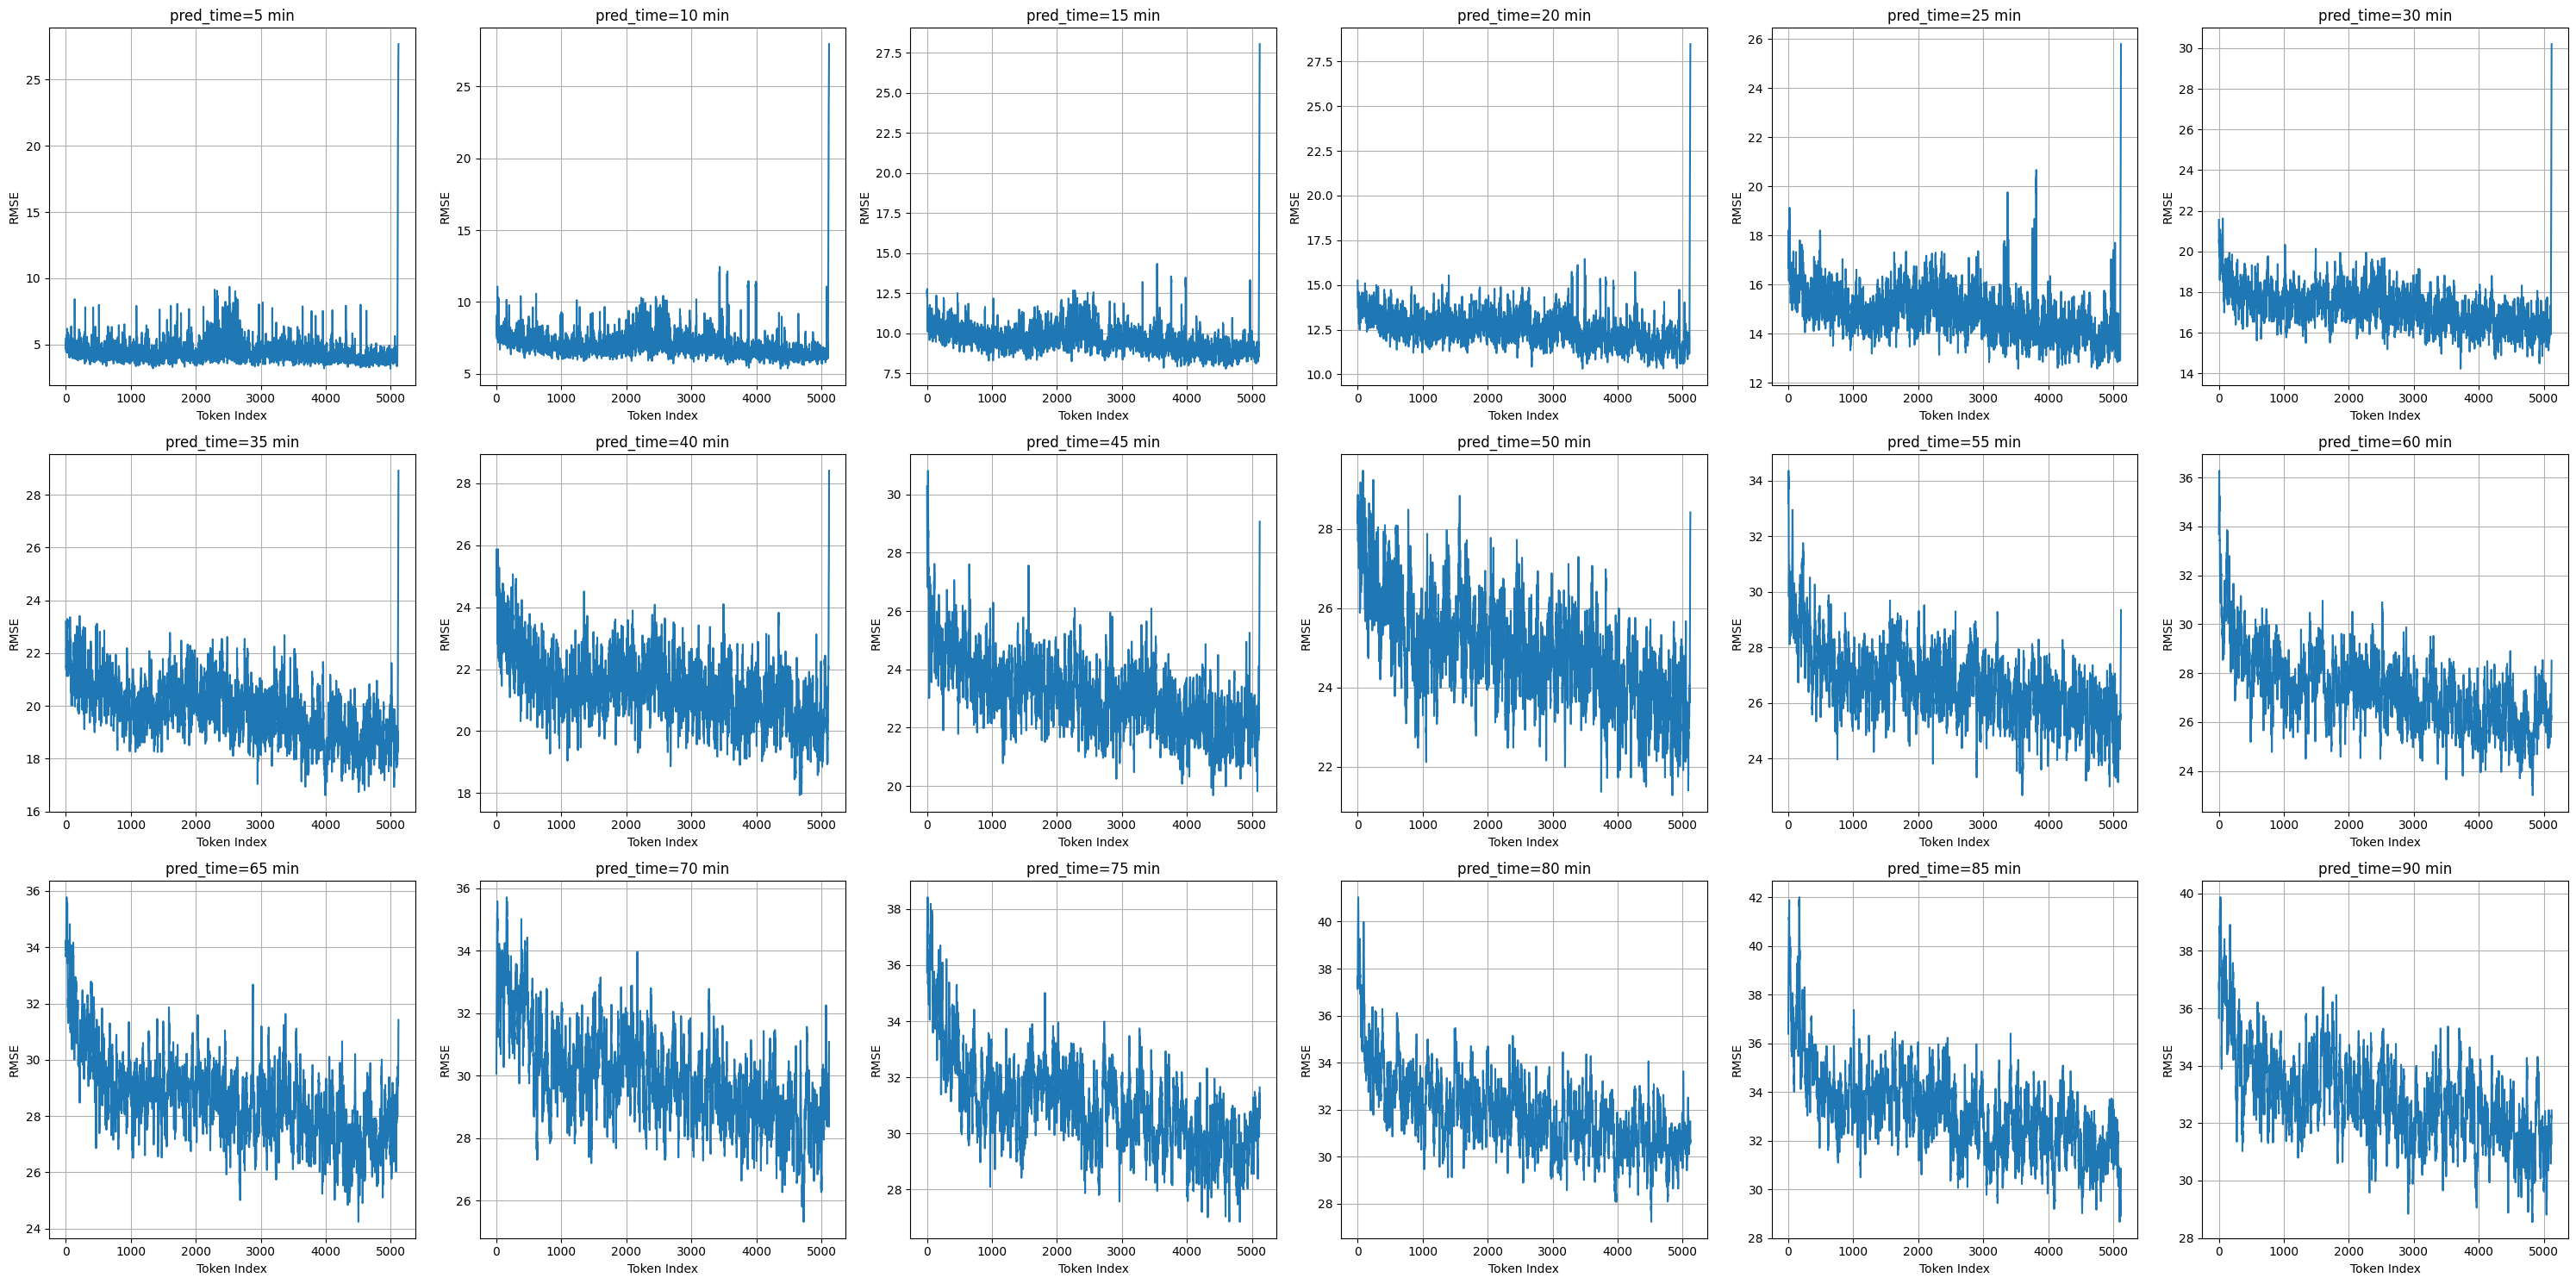

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def loss(out, target):
    return (out - target)**2

# Assuming the model, val_dataset, device, and criterion are already defined
num_iter = 1000
pred_time_range = range(1, 19)  # pred_time from 1 to 18
rmse_losses = []
# Create a grid for subplots
rows = 3  # Define the number of rows in the grid
cols = 6  # Define the number of columns in the grid
fig, axes = plt.subplots(rows, cols, figsize=(30, 15))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Outer loop for pred_time with tqdm for progress
for idx, pred_time in enumerate(pred_time_range):
    total_loss, total_samples = 0, 0

    # Inner loop for num_iter with tqdm for progress
    with torch.no_grad():
        for i in tqdm(range(num_iter), desc=f"Calculating for pred_time={pred_time * 5} min"):
            while total_samples < num_iter:
                sample = val_dataset[0]
                cgm = sample['cgm'].to(device).unsqueeze(0)
                basal = sample['basal'].to(device).unsqueeze(0)
                bolus = sample['bolus'].to(device).unsqueeze(0)
                cgm_time = sample['cgm_time'].to(device).unsqueeze(0)
                basal_time = sample['basal_time'].to(device).unsqueeze(0)
                bolus_time = sample['bolus_time'].to(device).unsqueeze(0)
                target_cgm = sample['target_cgm'].to(device)
                target_time = sample['target_time'].to(device)

                # Use the entire token sequence
                target_time = target_time.unsqueeze(0)
                target_cgm = target_cgm.unsqueeze(0)

                if bolus.shape[1] > 0 and basal.shape[1] > 0:
                    output_cgm = model(cgm, basal, bolus, cgm_time, basal_time, bolus_time, target_time, pred_time)
                    
                    # Calculate loss for each token
                    total_loss = total_loss + loss(output_cgm, target_cgm).to('cpu')[0]
                    
                    total_samples += 1
                    break

    # Plot unnormalized RMSE against token index for the current pred_time
    ax = axes[idx]  # Select the appropriate subplot
    rmse_losses.append((total_loss / total_samples)**0.5)
    ax.plot(range(len(total_loss)), (total_loss / total_samples)**0.5)
    ax.set_title(f'pred_time={pred_time * 5} min')
    ax.set_xlabel('Token Index')
    ax.set_ylabel('RMSE')
    ax.grid(True)  # Add grid for better readability

# Adjust layout for better appearance
plt.tight_layout()
plt.savefig("rmse.png", dpi=300)
plt.show()

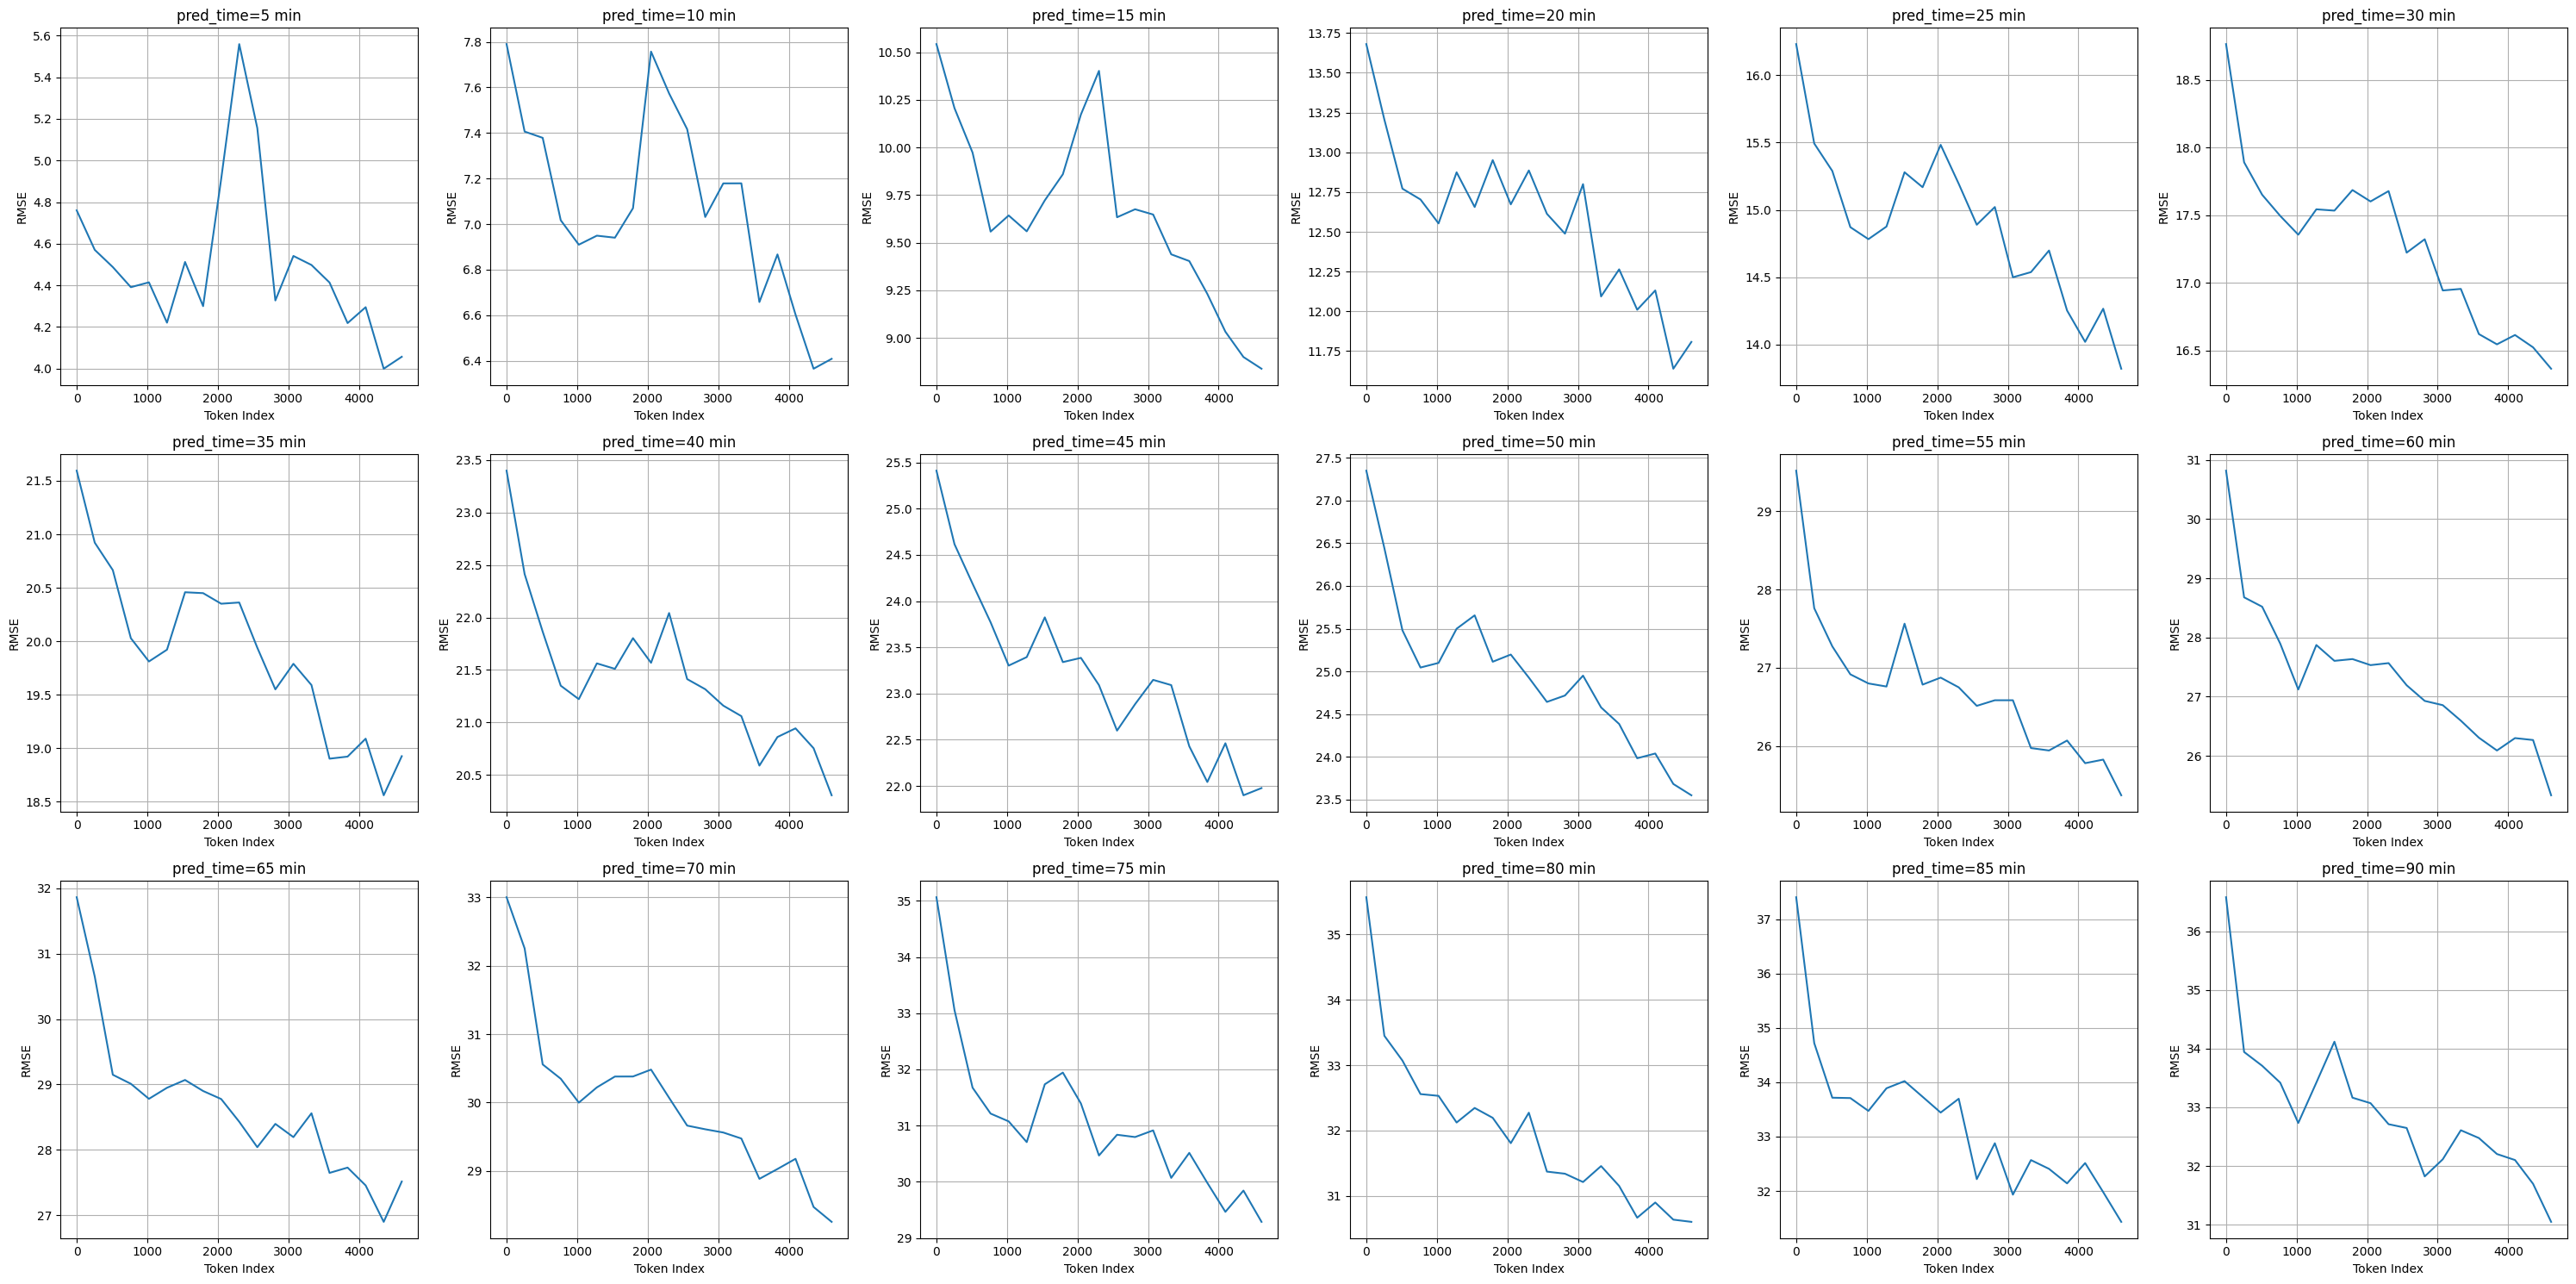

In [93]:
# Assuming rmse_losses is defined and contains the appropriate data
pred_time_range = range(1, 19)
rows, cols = 3, 6  # Define grid size to fit all plots
fig, axes = plt.subplots(rows, cols, figsize=(30, 15))
axes = axes.flatten()

for idx, pred_time in enumerate(pred_time_range):
    loss = []
    time = []
    
    for i, l in enumerate(rmse_losses[idx][:-32]):
        loc = i // 256
        if len(loss) <= loc:
            loss.append(0)
            time.append(loc * 256)
        loss[loc] += (l**2)/256

    loss = torch.tensor(loss[:-1]) ** 0.5
    time = time[:-1]
    ax = axes[idx]  # Select the appropriate subplot
    ax.plot(time, loss)
    ax.set_title(f'pred_time={pred_time * 5} min')
    ax.set_xlabel('Token Index')
    ax.set_ylabel('RMSE')
    ax.grid(True)  # Add grid for better readability

# Adjust layout for better appearance
plt.tight_layout()
plt.savefig("rmse.png", dpi=300)
plt.show()


/tmp/ipykernel_109725/1394477670.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rmse = torch.tensor(loss) ** 0.5
/tmp/ipykernel_109725/1394477670.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


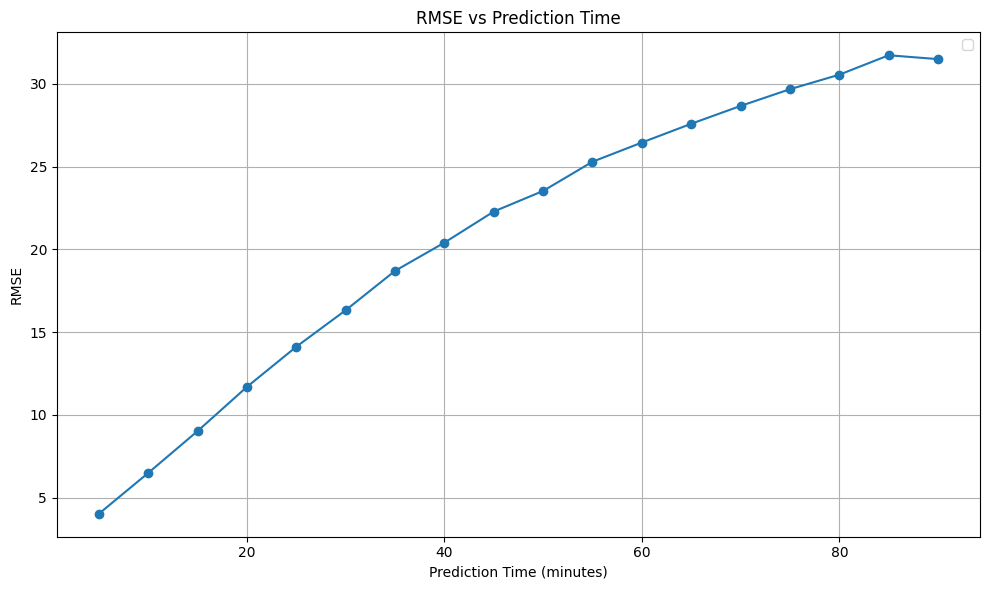

In [100]:
pred_time_range = range(1, 19)
rmse_values = []  # To store the RMSE of the last 256 tokens for each pred_time
pred_times = []   # To store the corresponding prediction times in minutes

# Iterate over each prediction time
for idx, pred_time in enumerate(pred_time_range):
    # Compute the RMSE of the last 256 tokens
    loss = 0
    for l in rmse_losses[idx][-256-32:-32]:
        loss += (l ** 2) / 256
    rmse = torch.tensor(loss) ** 0.5
    
    # Store the results
    rmse_values.append(rmse.item())
    pred_times.append(pred_time * 5)  # Convert pred_time to minutes

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(pred_times, rmse_values, marker='o')
plt.title('RMSE vs Prediction Time')
plt.xlabel('Prediction Time (minutes)')
plt.ylabel('RMSE')
plt.grid(True)  # Add grid for better readability
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig("rmse_single_plot.png", dpi=300)
plt.show()

In [83]:
torch.save(rmse_losses, "rmse_losses.pt")

Calculating for pred_time=90 min: 100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


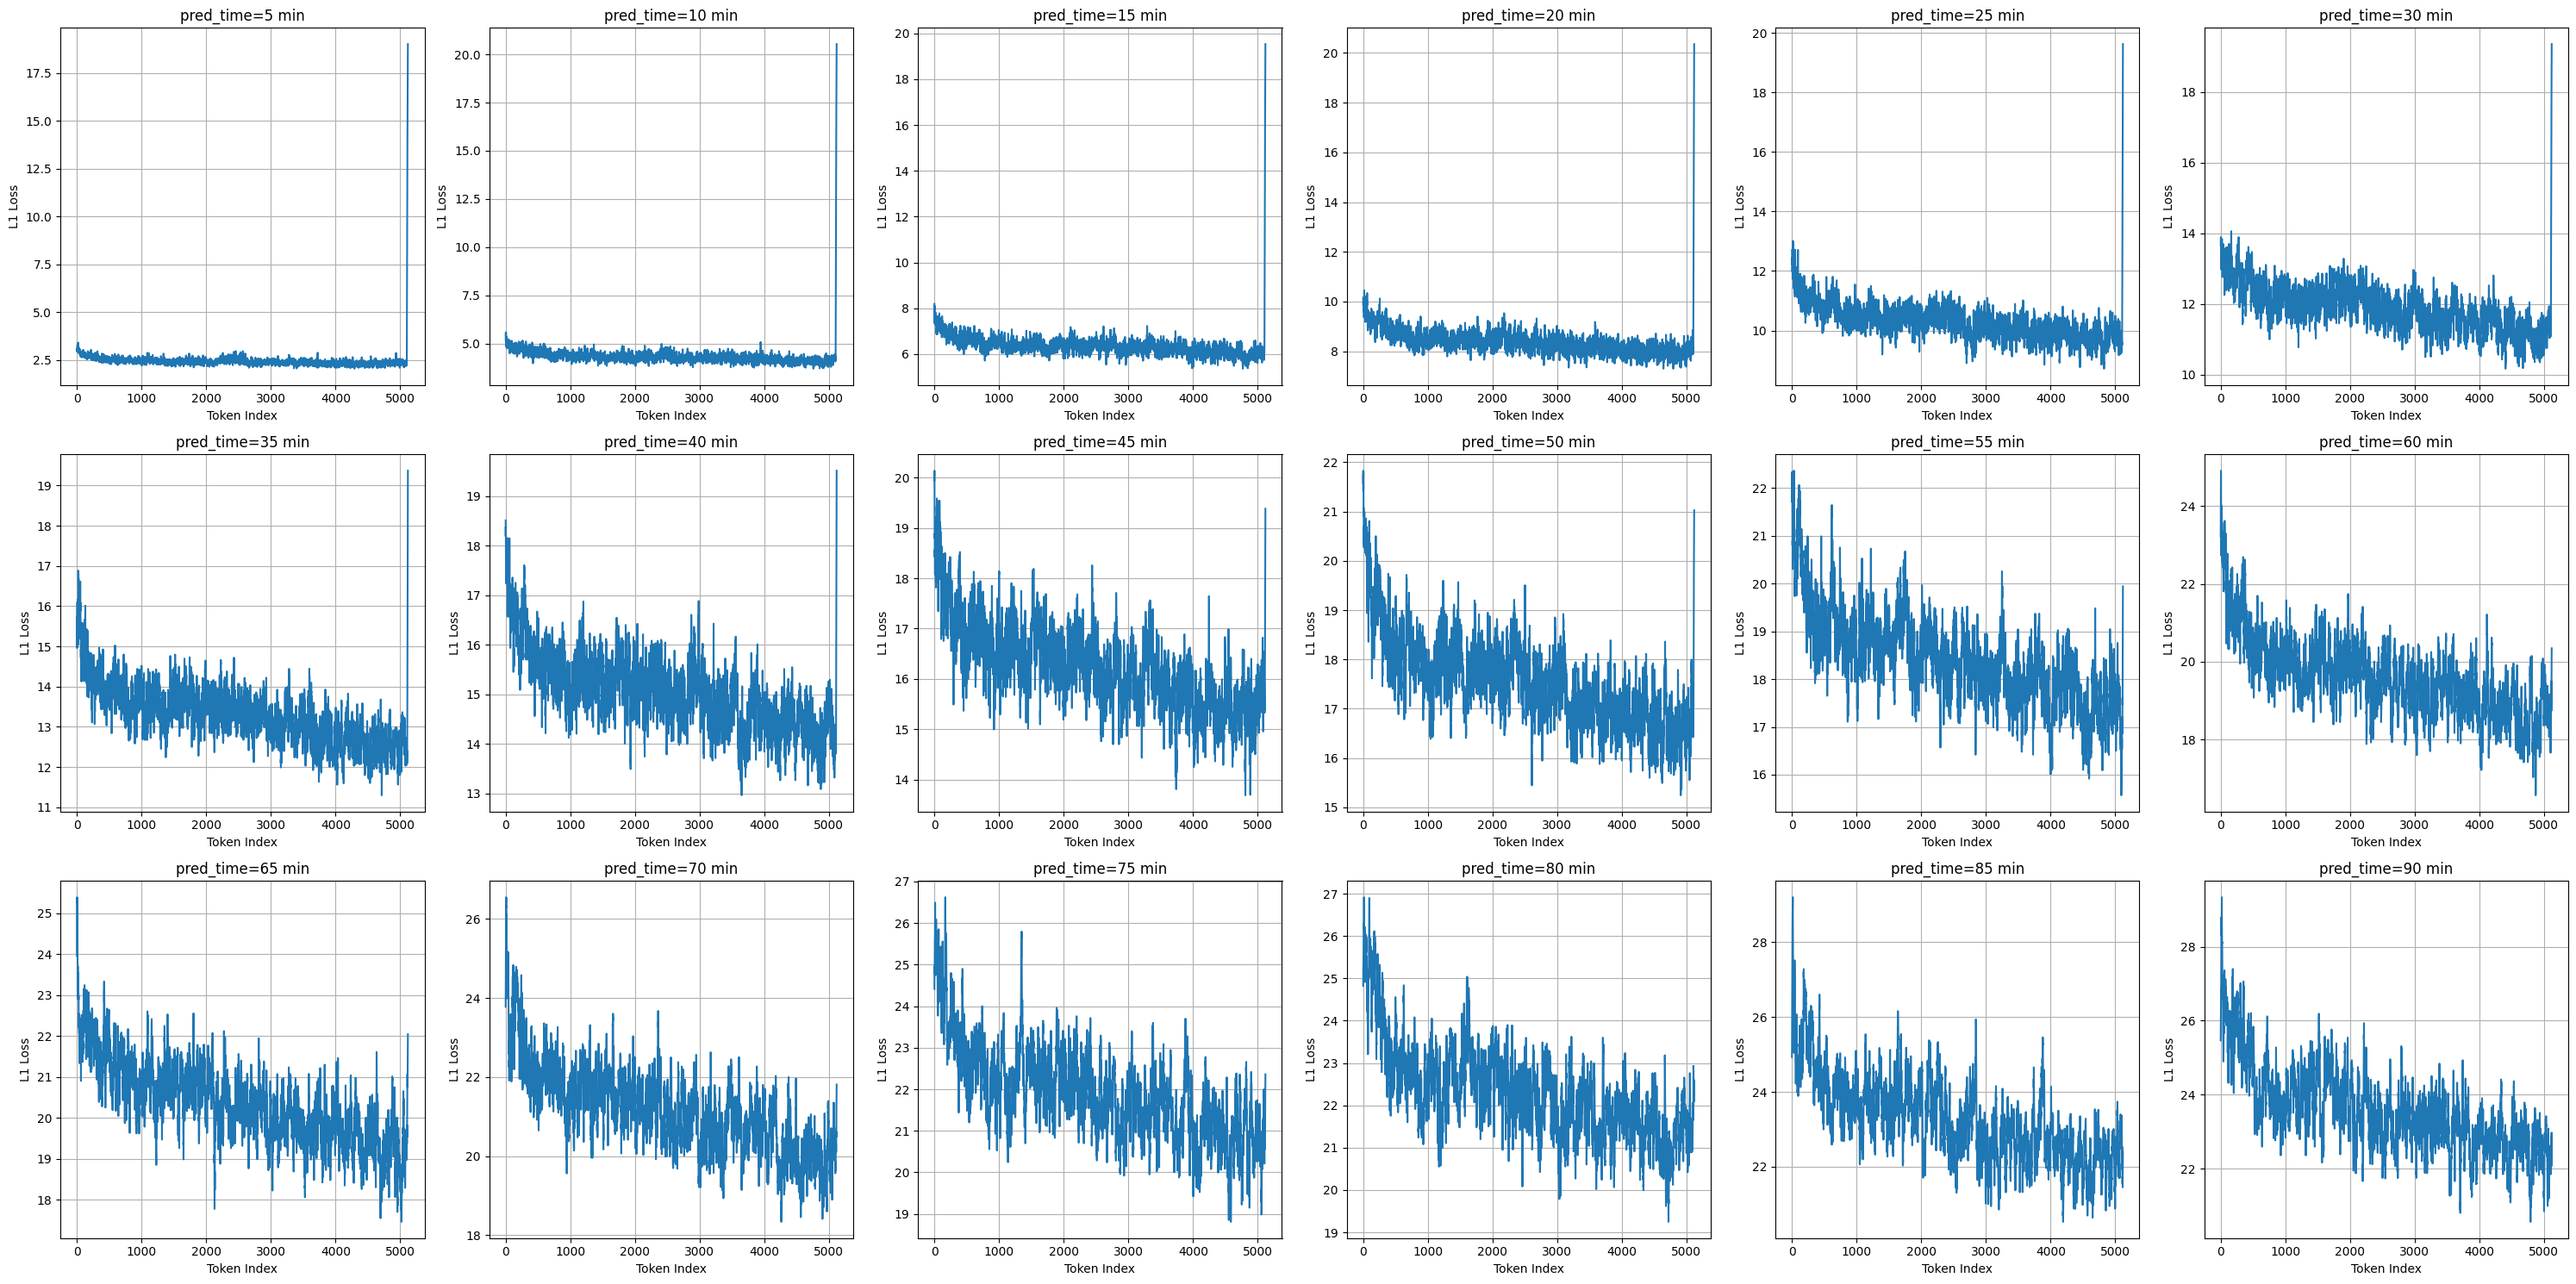

In [84]:
def loss(out, target):
    return torch.abs(out - target)

# Assuming the model, val_dataset, device, and criterion are already defined
num_iter = 1000
pred_time_range = range(1, 19)  # pred_time from 1 to 18
l1_losses = []
# Create a grid for subplots
rows = 3  # Define the number of rows in the grid
cols = 6  # Define the number of columns in the grid
fig, axes = plt.subplots(rows, cols, figsize=(30, 15))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Outer loop for pred_time with tqdm for progress
for idx, pred_time in enumerate(pred_time_range):
    total_loss, total_samples = 0, 0

    # Inner loop for num_iter with tqdm for progress
    with torch.no_grad():
        for i in tqdm(range(num_iter), desc=f"Calculating for pred_time={pred_time * 5} min"):
            while total_samples < num_iter:
                sample = val_dataset[0]
                cgm = sample['cgm'].to(device).unsqueeze(0)
                basal = sample['basal'].to(device).unsqueeze(0)
                bolus = sample['bolus'].to(device).unsqueeze(0)
                cgm_time = sample['cgm_time'].to(device).unsqueeze(0)
                basal_time = sample['basal_time'].to(device).unsqueeze(0)
                bolus_time = sample['bolus_time'].to(device).unsqueeze(0)
                target_cgm = sample['target_cgm'].to(device)
                target_time = sample['target_time'].to(device)

                # Use the entire token sequence
                target_time = target_time.unsqueeze(0)
                target_cgm = target_cgm.unsqueeze(0)

                if bolus.shape[1] > 0 and basal.shape[1] > 0:
                    output_cgm = model(cgm, basal, bolus, cgm_time, basal_time, bolus_time, target_time, pred_time)
                    
                    # Calculate loss for each token
                    total_loss = total_loss + loss(output_cgm, target_cgm).to('cpu')[0]
                    
                    total_samples += 1
                    break

    ax = axes[idx]  # Select the appropriate subplot
    l1_losses.append((total_loss / total_samples))
    ax.plot(range(len(total_loss)), (total_loss / total_samples))
    ax.set_title(f'pred_time={pred_time * 5} min')
    ax.set_xlabel('Token Index')
    ax.set_ylabel('L1 Loss')
    ax.grid(True)  # Add grid for better readability

# Adjust layout for better appearance
plt.tight_layout()
plt.savefig("l1.png", dpi=300)
plt.show()

In [89]:
torch.save(l1_losses, "l1_losses.pt")

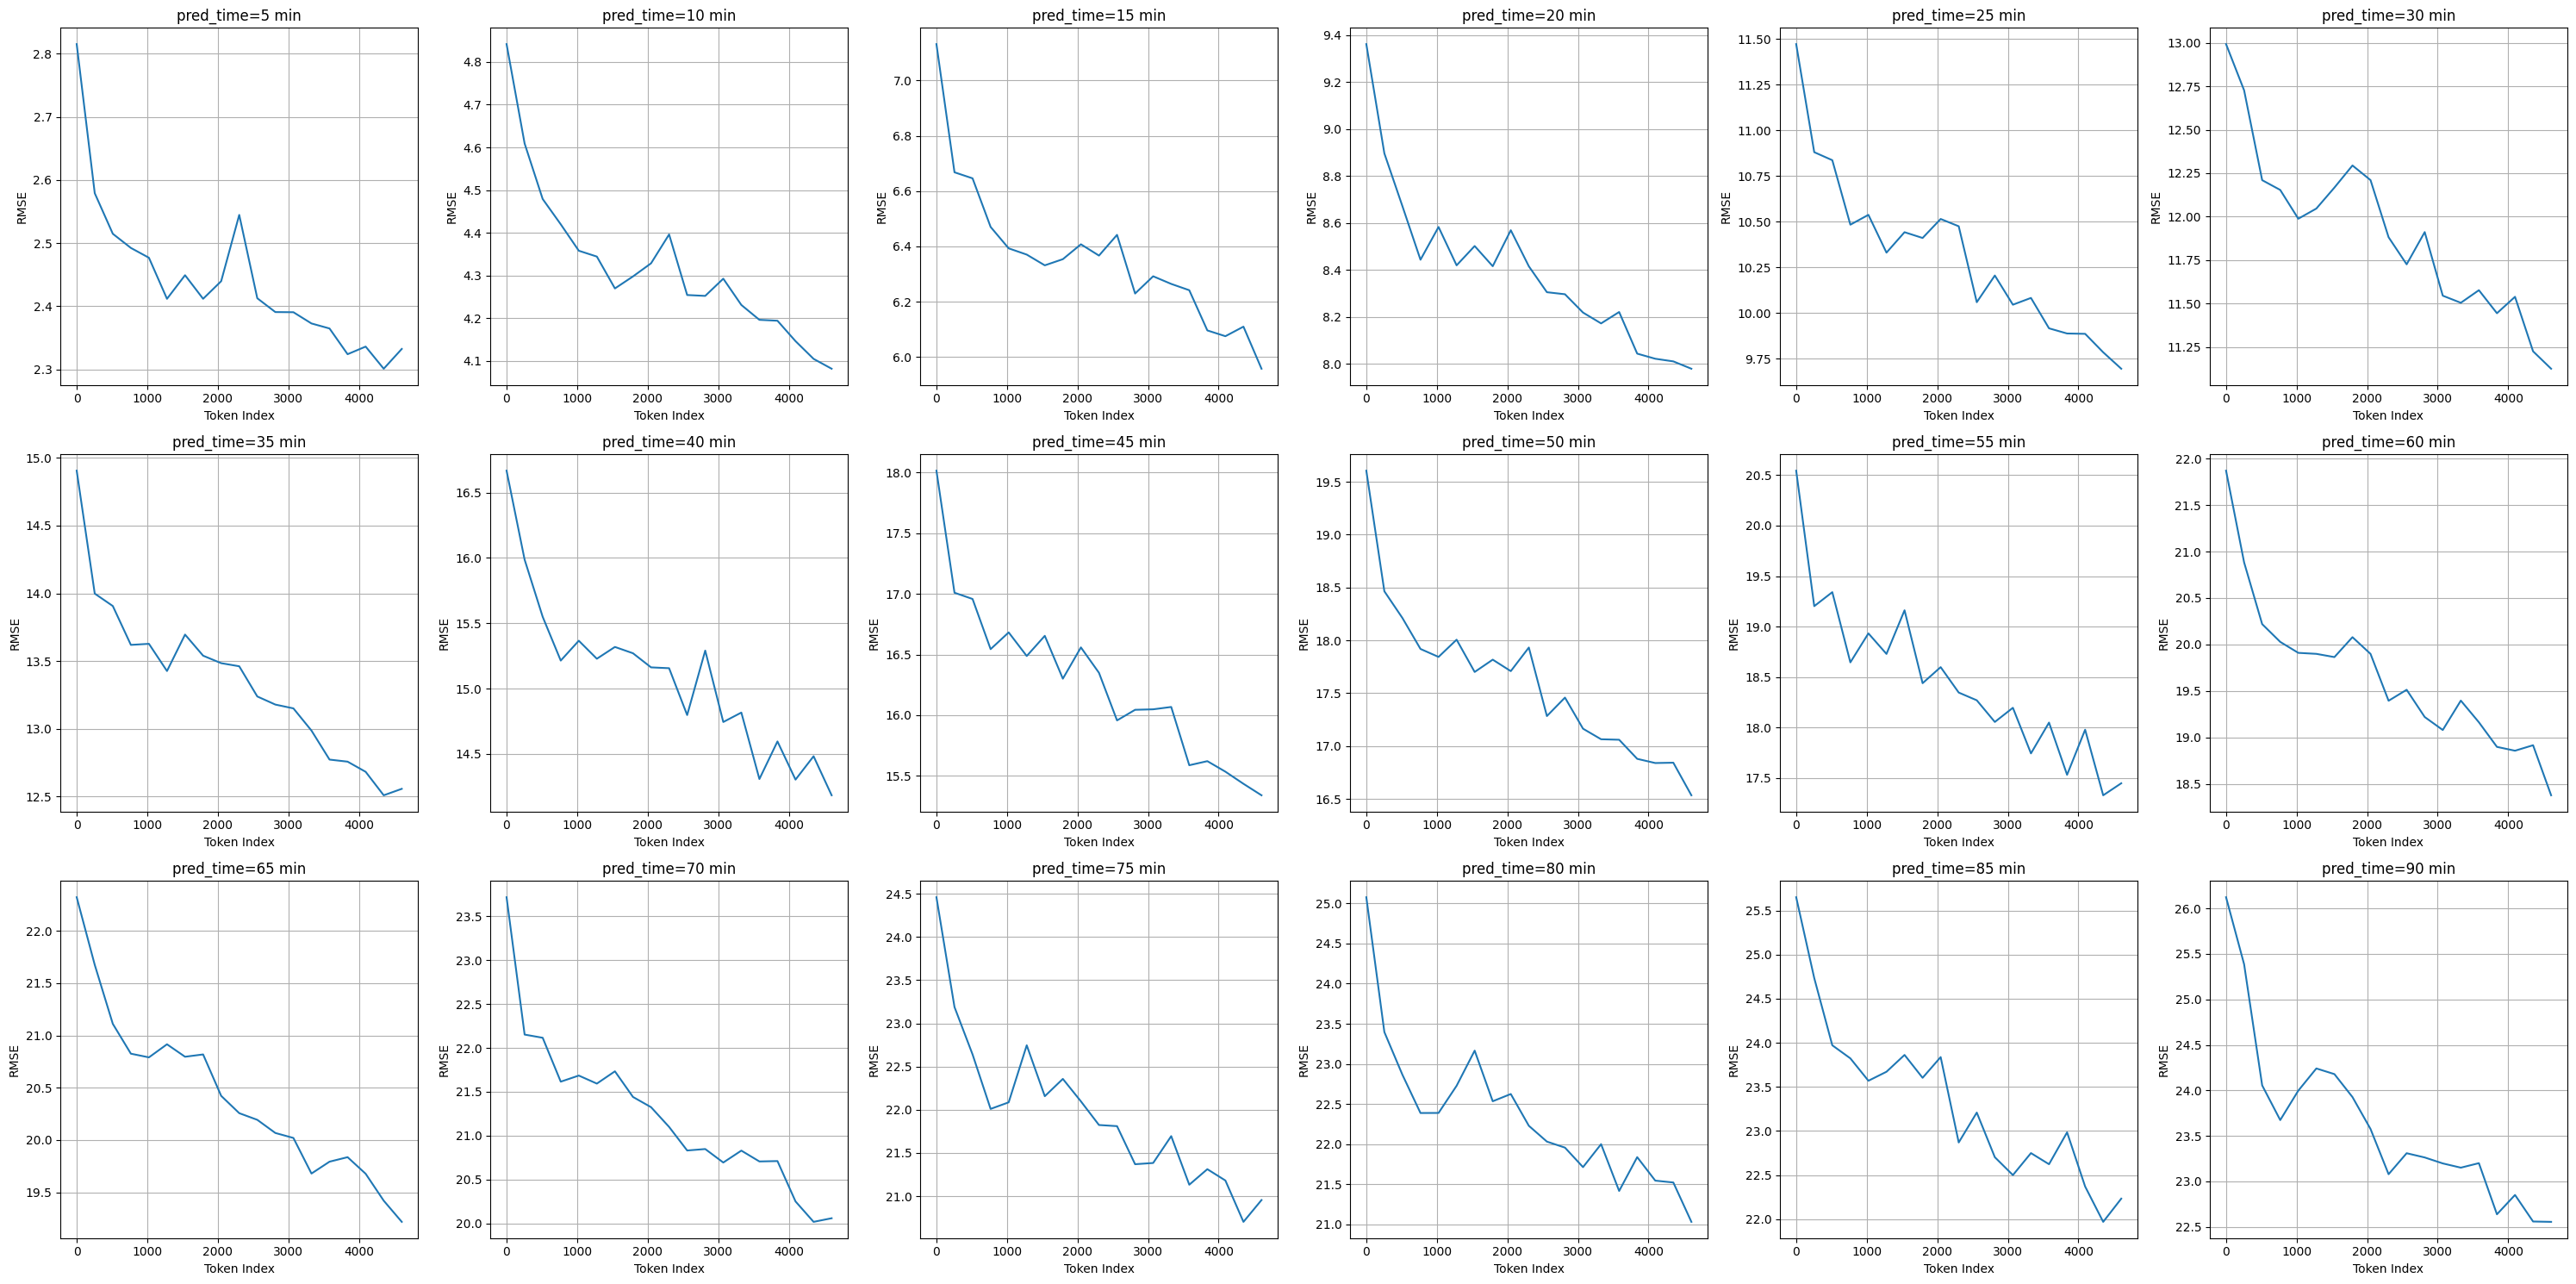

In [94]:
# Assuming rmse_losses is defined and contains the appropriate data
pred_time_range = range(1, 19)
rows, cols = 3, 6  # Define grid size to fit all plots
fig, axes = plt.subplots(rows, cols, figsize=(30, 15))
axes = axes.flatten()

for idx, pred_time in enumerate(pred_time_range):
    loss = []
    time = []
    
    for i, l in enumerate(l1_losses[idx][:-32]):
        loc = i // 256
        if len(loss) <= loc:
            loss.append(0)
            time.append(loc * 256)
        loss[loc] += (l**2)/256

    loss = torch.tensor(loss[:-1]) ** 0.5
    time = time[:-1]
    ax = axes[idx]  # Select the appropriate subplot
    ax.plot(time, loss)
    ax.set_title(f'pred_time={pred_time * 5} min')
    ax.set_xlabel('Token Index')
    ax.set_ylabel('RMSE')
    ax.grid(True)  # Add grid for better readability

# Adjust layout for better appearance
plt.tight_layout()
plt.savefig("l1.png", dpi=300)
plt.show()


/tmp/ipykernel_109725/2979356525.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l1 = torch.tensor(loss)
/tmp/ipykernel_109725/2979356525.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


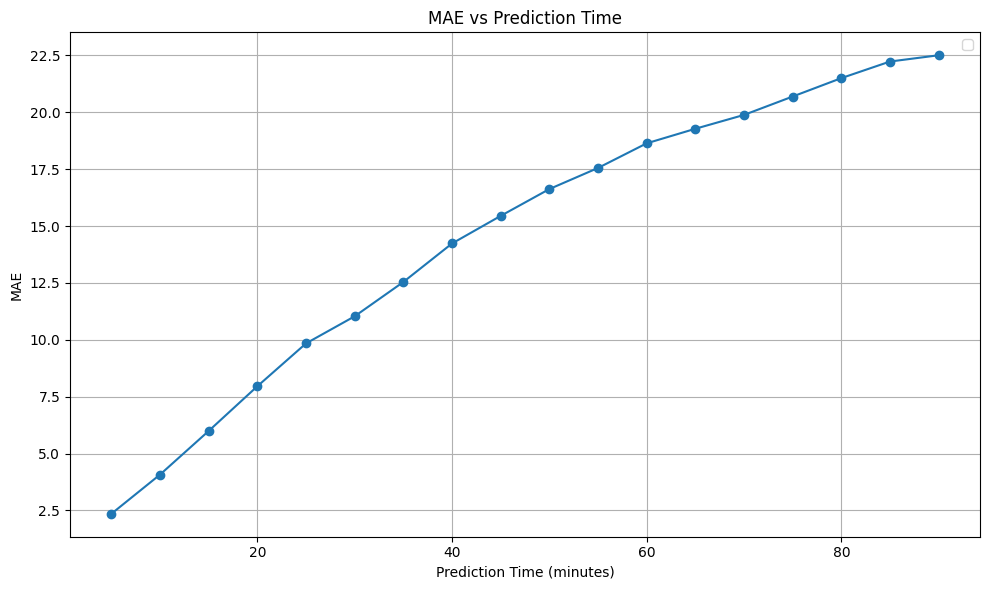

In [99]:
pred_time_range = range(1, 19)
l1_values = [] 
pred_times = []  

for idx, pred_time in enumerate(pred_time_range):
    loss = 0
    for l in l1_losses[idx][-256-32:-32]:
        loss += l / 256
    l1 = torch.tensor(loss)
    
    # Store the results
    l1_values.append(l1.item())
    pred_times.append(pred_time * 5)  # Convert pred_time to minutes

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(pred_times, l1_values, marker='o')
plt.title('MAE vs Prediction Time')
plt.xlabel('Prediction Time (minutes)')
plt.ylabel('MAE')
plt.grid(True)  # Add grid for better readability
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig("l1_single_plot.png", dpi=300)
plt.show()